In [1]:
!pip uninstall -y openai
!pip install openai==1.55.3

Found existing installation: openai 1.109.1
Uninstalling openai-1.109.1:
  Successfully uninstalled openai-1.109.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 7.7 MB/s eta 0:00:00


In [4]:
!pip install --upgrade openai pandas  # Install / upgrade required packages

import os      # For environment variables
import time    # For sleep() in retry logic
from openai import OpenAI  # OpenAI client
import pandas as pd        # For reading / writing Excel files
import re                  # For simple text cleaning

# Set API Key (replace with your own key, do NOT hard-code in public code)
os.environ["OPENAI_API_KEY"] = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])  # Create OpenAI client

# Load the Excel file that contains the comments
file_path = 'mediheal response.xlsx'
df = pd.read_excel(file_path, header=None)

# Take the first column (except header row), drop NaN, convert to string list
comments = df.iloc[1:, 0].dropna().astype(str).tolist()

# Function to convert one comment into standard Korean using OpenAI
def correct_to_standard(text):
    retry = 0  # Retry counter
    while retry < 5:  # Try up to 5 times
        try:
            res = client.chat.completions.create(
                model="gpt-3.5-turbo",  # NOTE: consider replacing with "gpt-4o-mini"
                messages=[
                    {"role": "system", "content": "You are a Korean proofreading expert."},
                    {"role": "user",
                     "content": f"Please rewrite the following sentence in standard and natural Korean:\n{text[:1000]}"}
                ],
                max_tokens=120,  # Maximum length of the answer
                temperature=0.4, # Low randomness for more stable correction
            )
            # Return the corrected text
            return res.choices[0].message.content.strip()
        except Exception as e:  # Catch any API error
            retry += 1  # Increase retry count
            wait = 3 * (2 ** retry)  # Exponential backoff
            print(f"[Correction] Retry {retry} ... waiting {wait} seconds | Error: {e}")
            time.sleep(wait)  # Wait before next try
    # If all retries fail, return the original text
    return text

# Function to generate a short keyword-style summary for one comment
def generate_summary(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # If text is too short, skip summarization
    if len(text) < 3:
        return ""
    try:
        res = client.chat.completions.create(
            model="gpt-3.5-turbo",  # NOTE: consider replacing with "gpt-4o-mini"
            messages=[
                {"role": "system",
                 "content": "Summarize the core content using only key words in Korean."},
                {"role": "user", "content": text[:1000]}
            ],
            max_tokens=40,   # Short summary
            temperature=0.5, # Slight randomness for variation
        )
        # Return summarized text
        return res.choices[0].message.content.strip()
    except Exception as e:  # Catch any API error
        print(f"[Summary error] {e}")
        return ""

# Lists to store corrected comments and summaries
corrected_comments = []
summarized_comments = []

print("Processing started...")

# Loop through all comments
for i, comment in enumerate(comments):
    print(f"Processing {i+1}/{len(comments)} ...")

    # Correct to standard Korean
    corrected = correct_to_standard(comment)
    corrected_comments.append(corrected)

    # Generate summary from corrected text
    summary = generate_summary(corrected)
    summarized_comments.append(summary)

print("All comments processed.")

# Create a DataFrame with original, corrected, and summarized comments
output_df = pd.DataFrame({
    'Original Comment': comments,
    'Corrected Comment (Standard Korean)': corrected_comments,
    'Summarized Comment': summarized_comments
})

# Save the result as a new Excel file
output_df.to_excel('Comment_mediheal_response_summary.xlsx', index=False)
print("Saved to Comment_mediheal_response_summary.xlsx")

Saved to Comment_mediheal_response_summary.xlsx


In [7]:
# Install required libs
!pip install -q transformers torch accelerate

In [10]:
# Install required libraries (run once)
!pip install -q konlpy transformers torch accelerate

import pandas as pd
import re
from konlpy.tag import Okt
from transformers import pipeline
from collections import Counter

# ---------------------------------------------------
# 1. Load Excel file
# ---------------------------------------------------
file_path = "Comment_mediheal_response_summary.xlsx"
df = pd.read_excel(file_path)

# Columns (Korean headers as in your file)
col_original = "원본 댓글"
col_corrected = "표준어로 변환된 댓글"
col_summary = "요약된 댓글"

# Basic check
for col in [col_original, col_corrected, col_summary]:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in Excel file.")

# ---------------------------------------------------
# 2. Extract important words using Okt
# ---------------------------------------------------
okt = Okt()

# Define simple Korean stopwords
stop_words = ['이', '그', '저', '은', '는', '이었', '였',
              '하다', '에', '을', '를', '있다', '의', '가']

def extract_important_words(comment: str):
    """Clean text and return morphemes without stopwords."""
    comment = re.sub(r'[^\w\s]', '', str(comment))  # Remove special characters
    comment = re.sub(r'\d+', '', comment)           # Remove numbers
    comment = comment.strip()

    if len(comment) == 0:
        return []

    words = okt.morphs(comment)                     # Tokenize into morphemes
    filtered = [w for w in words if w not in stop_words]
    return filtered

# Apply to each corrected comment
corrected_comments = df[col_corrected].fillna("").astype(str).tolist()
important_words_per_comment = [extract_important_words(c) for c in corrected_comments]

# (Optional) Preview first few results
print("=== Sample important words per comment ===")
for i, words in enumerate(important_words_per_comment[:5]):
    print(f"Comment {i+1}: {words}")
print()

# ---------------------------------------------------
# 3. Prepare text for sentiment analysis
#    Use summarized text; if NaN, fallback to corrected text
# ---------------------------------------------------
texts_series = df[col_summary]

# Fallback if summary is NaN or empty
mask_empty = texts_series.isna() | (texts_series.astype(str).str.strip() == "")
texts_series = texts_series.astype(str)
texts_series[mask_empty] = df.loc[mask_empty, col_corrected].astype(str)

# Remove completely empty rows
texts = texts_series.astype(str).str.strip()
texts = texts[texts != ""].tolist()

if len(texts) == 0:
    raise ValueError("No valid text found for sentiment analysis.")

# ---------------------------------------------------
# 4. Load Korean sentiment model
#    Model outputs LABEL_0 / LABEL_1 / LABEL_2
#    We manually map them to negative / neutral / positive.
# ---------------------------------------------------
model_name = "alsgyu/sentiment-analysis-fine-tuned-model"

sentiment_pipe = pipeline(
    task="text-classification",
    model=model_name,
    tokenizer=model_name,
    truncation=True,
    padding=True
)

# ---------------------------------------------------
# 5. Run sentiment prediction
# ---------------------------------------------------
results = sentiment_pipe(texts)   # List of dicts: {"label": "LABEL_0", "score": ...}

# Map raw labels to Korean sentiment names
label_map = {
    "LABEL_0": "부정",
    "LABEL_1": "중립",
    "LABEL_2": "긍정",
    "negative": "부정",
    "neutral": "중립",
    "positive": "긍정",
}

mapped_labels = [label_map.get(r["label"], "Unknown") for r in results]

# Count each sentiment
counts = Counter(mapped_labels)
total = counts["긍정"] + counts["중립"] + counts["부정"]

if total == 0:
    print("No valid sentiment predictions. Raw labels sample:")
    print(results[:5])
else:
    perc = {
        "긍정": round(counts["긍정"] / total * 100, 1),
        "중립": round(counts["중립"] / total * 100, 1),
        "부정": round(counts["부정"] / total * 100, 1),
    }

    print("=== Sentiment distribution (%) ===")
    print(f"긍정: {perc['긍정']}%")
    print(f"중립: {perc['중립']}%")
    print(f"부정: {perc['부정']}%")


=== Sample important words per comment ===
Comment 1: ['진짜', '배송', '때문', '이런', '리뷰', '쓰게', '되다니', '정말', '처음', '이네', '요', '\n ', '배송', '완료', '만', '떠', '있고', '상품', '아직', '도착', '하지', '않았습니다', '\n ', '배송', '확인', '사진', '보니', '제', '지정', '한', '장소', '아닌', '다른', '곳', '놓여', '있습니다', '\n ', '아파트', '주변', '모두', '뒤져']
Comment 2: ['제품', '할인', '도', '받을', '수', '있고', '유튜브', '에서도', '좋다고', '해서', '이번', '제품', '구성', '도', '좋아서', '매장', '가서', '테스트', '해보고', '구매', '했는데', '역시', '나', '제', '얼굴', '너무', '민감한', '것', '같습니다', '제품', '사용', '하고', '나서', '얼굴', '전체', '적', '으로', '좁쌀', '여드름', '퍼지는', '것', '같']
Comment 3: ['민감', '성', '테스트', '필수', '\n\n', '실링', '지', '정말', '어렵게', '뜯어지네요', '아직', '사용', '하기도', '전', '화가', '났어요', 'ㅎㅎ', '여행', '갈', '때', '가져가지', '말아야', '할', '것', '같아요', '다', '새', '요', 'ㅜ', '\n', '그리고', '집게', '정말', '뭐', '에요', '지금', '까지', '사용', '해', '본', '것', '중', '가장', '불']
Comment 4: ['주변', '에서', '칭찬', '많이', '받아서', '구매', '했는데', '제', '게', '맞지', '않았어요', '사용', '시작', '한', '이틀', '째', '부터', '사용', '후', '분', '지나면', '너무', '따가웠어요', '그래

Device set to use cpu


=== Sentiment distribution (%) ===
긍정: 60.6%
중립: 22.2%
부정: 17.2%


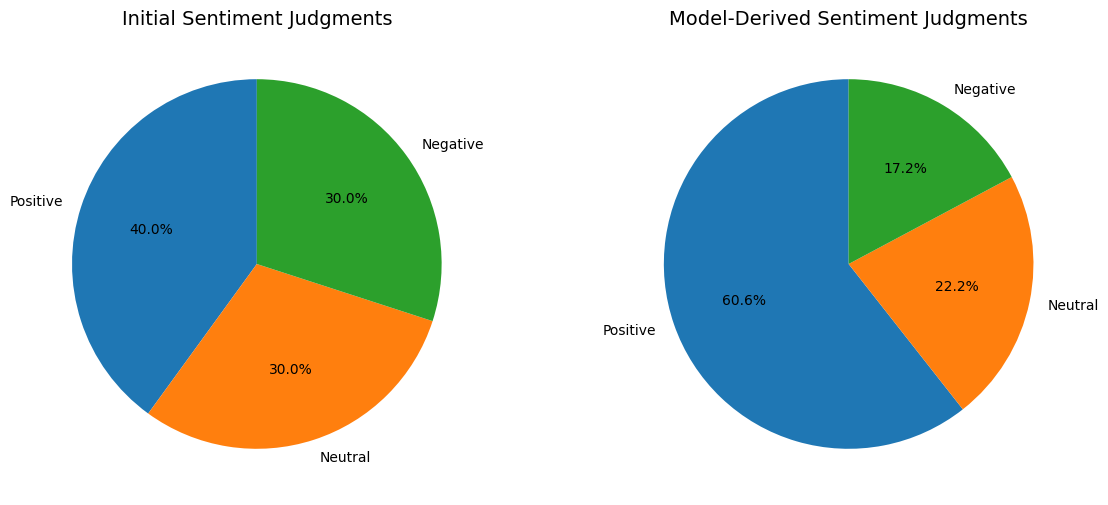

In [11]:
import matplotlib.pyplot as plt

# === Initial Expectation (English) ===
initial_percentages_en = {
    "Positive": 40.0,
    "Neutral": 30.0,
    "Negative": 30.0
}

# === Model Results (English) ===
model_percentages_en = {
    "Positive": 60.6,
    "Neutral": 22.2,
    "Negative": 17.2
}

labels_en = ["Positive", "Neutral", "Negative"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

values_initial = [initial_percentages_en[l] for l in labels_en]
values_model = [model_percentages_en[l] for l in labels_en]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left: Initial
ax[0].pie(values_initial, labels=labels_en, autopct='%.1f%%',
          startangle=90, colors=colors)
ax[0].set_title("Initial Sentiment Judgments", fontsize=14)

# Right: Model-based
ax[1].pie(values_model, labels=labels_en, autopct='%.1f%%',
          startangle=90, colors=colors)
ax[1].set_title("Model-Derived Sentiment Judgments", fontsize=14)

plt.show()


In [12]:
import numpy as np

# Initial expected sentiment percentages
initial = np.array([40.0, 30.0, 30.0])   # Positive, Neutral, Negative

# Model-derived sentiment percentages (Your results)
model = np.array([60.6, 22.2, 17.2])     # Positive, Neutral, Negative

# MAE calculation
mae = np.mean(np.abs(initial - model))

print(f"Mean Absolute Error (MAE) between initial and model sentiment judgments: {mae:.2f}%")


Mean Absolute Error (MAE) between initial and model sentiment judgments: 13.73%
